In [17]:
import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split

In [56]:
da = pd.read_excel('classes.xlsx')
da.to_feather('classes.feather')

In [18]:
data1 = pd.read_feather('data1.feather')
class_ = data1['class']
data = pd.read_feather('features1.feather')
# 假设你的特征集是 data，目标变量是 class_
X = data.values  # 特征集
y = class_.values  # 目标变量

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data_with_class = data.copy()
data_with_class['class'] = class_


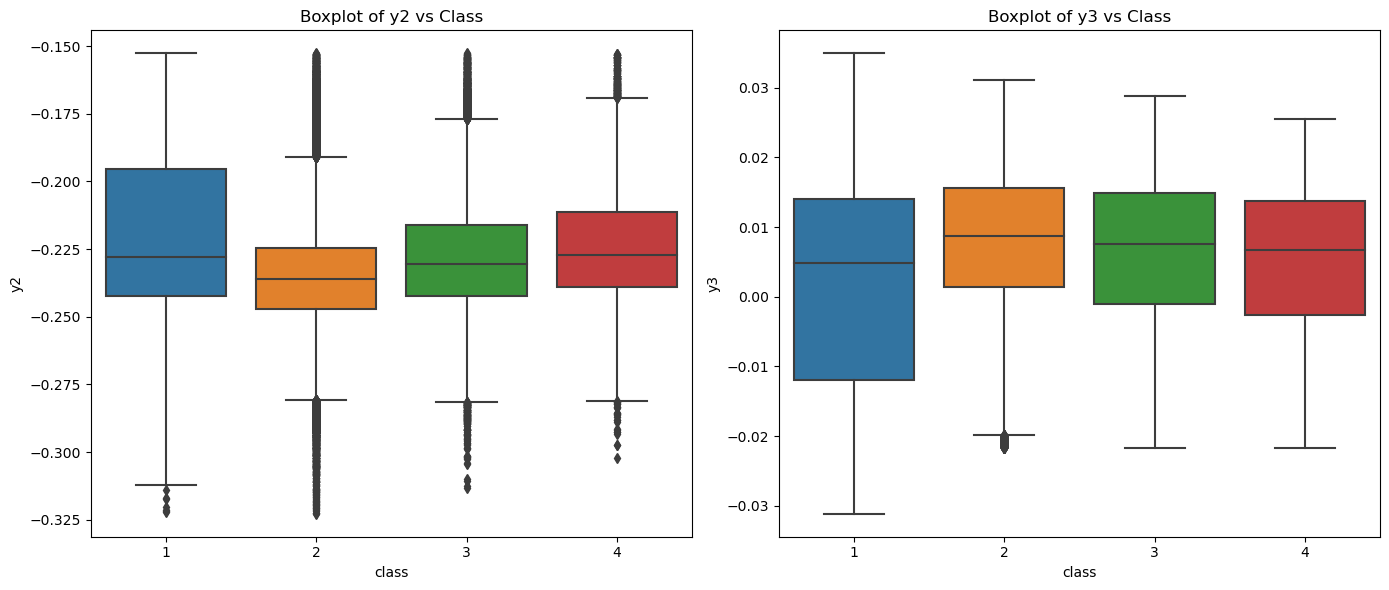

In [4]:
# for feature in data.columns:
# 设置图表的大小
plt.figure(figsize=(14, 6))

# 第一个子图: y1 vs class
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='y2', data=data_with_class)
plt.title('Boxplot of y2 vs Class')

# 第二个子图: y2 vs class
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='y3', data=data_with_class)
plt.title('Boxplot of y3 vs Class')

# 显示图表
plt.tight_layout()  # 使子图布局更紧凑
plt.show()

IQR

In [45]:
# 使用 IQR 方法对每个类别的数据进行清理
def remove_outliers_iqr(df, multiplier=0.8):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    is_not_outlier = ~((df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))).any(axis=1)
    return df[is_not_outlier]

# 按类别进行清理
cleaned_data_list = []
for label in data_with_class['class'].unique():
    class_data = data_with_class[data_with_class['class'] == label]
    class_features = class_data.drop(columns=['class'])
    
    # 清理每个类别中的异常值
    cleaned_class_data = remove_outliers_iqr(class_features)
    
    # 将 'class' 列加回来
    cleaned_class_data['class'] = label
    
    cleaned_data_list.append(cleaned_class_data)

# 将清理后的数据合并成一个 DataFrame
cleaned_data_with_class = pd.concat(cleaned_data_list, ignore_index=True)

C:\Users\yangz\AppData\Local\Temp\ipykernel_300\1289563718.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_class_data['class'] = label
C:\Users\yangz\AppData\Local\Temp\ipykernel_300\1289563718.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_class_data['class'] = label
C:\Users\yangz\AppData\Local\Temp\ipykernel_300\1289563718.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

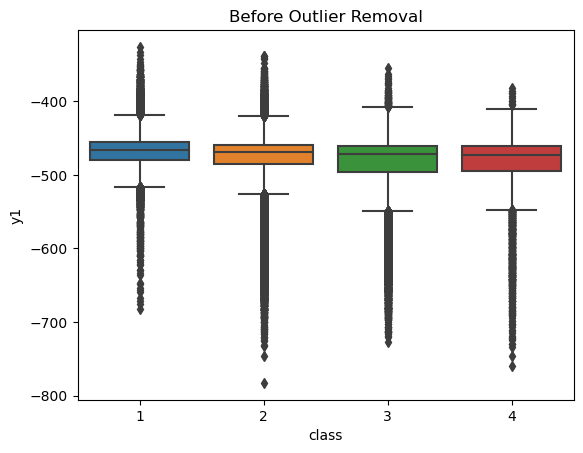

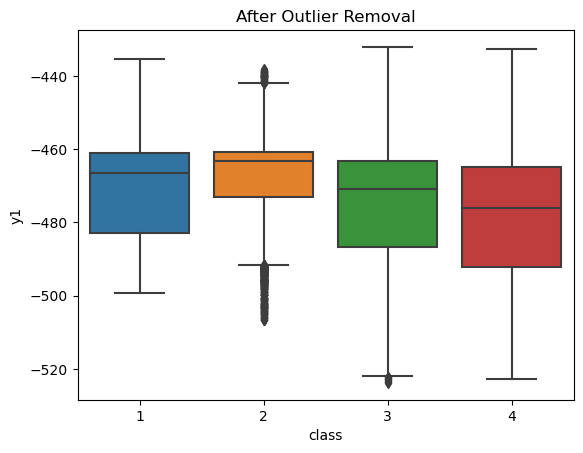

In [57]:
# 清理前的可视化
sns.boxplot(x='class', y='y1', data=data_with_class)
plt.title("Before Outlier Removal")
plt.show()

# 清理后的可视化
sns.boxplot(x='class', y='y1', data=cleaned_data_with_class)
plt.title("After Outlier Removal")
plt.show()

DBSCAN

In [20]:
from sklearn.cluster import DBSCAN
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 使用 DBSCAN 方法进行去噪
def remove_noise_dbscan(df, eps=0.6, min_samples=4):
    
    # 使用 DBSCAN 进行聚类
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(df)
    
    # 标记噪声点
    is_not_noise = dbscan_labels != -1
    return df[is_not_noise]

# 按类别进行去噪
denoised_data_list = []
for label in data_with_class['class'].unique():
    class_data = data_with_class[data_with_class['class'] == label]
    class_features = class_data.drop(columns=['class'])
    
    # 去噪每个类别中的数据
    denoised_class_data = remove_noise_dbscan(class_features)
    
    # 将 'class' 列加回来
    denoised_class_data['class'] = label
    
    denoised_data_list.append(denoised_class_data)

# 将去噪后的数据合并成一个 DataFrame
denoised_data_with_class = pd.concat(denoised_data_list, ignore_index=True)


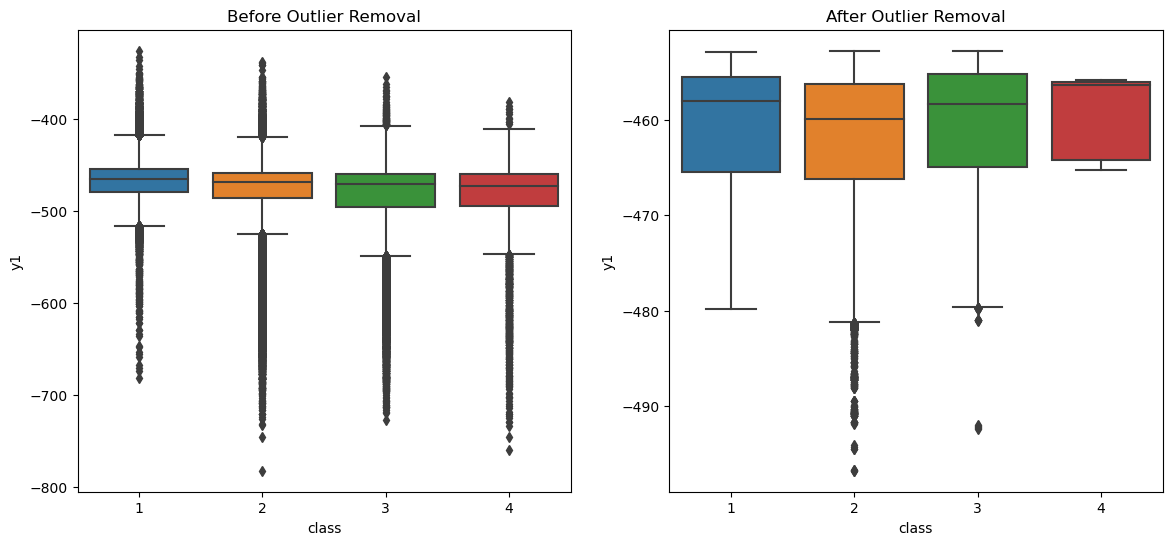

In [21]:
plt.figure(figsize=(14, 6))

# 第一个子图: y1 vs class
plt.subplot(1, 2, 1)
# 清理前的可视化
sns.boxplot(x='class', y='y1', data=data_with_class)
plt.title("Before Outlier Removal")
plt.subplot(1, 2, 2)
# 清理后的可视化
sns.boxplot(x='class', y='y1', data=denoised_data_with_class)
plt.title("After Outlier Removal")
plt.show()

滑动窗口

In [189]:
import numpy as np
def sliding_window_outlier_detection(df, column_name, window_size=50, z_threshold=3):
    """
    滑动窗口方法检测并标记异常值
    """
    outliers = np.zeros(len(df), dtype=bool)
    
    for i in range(len(df)):
        start = max(0, i - window_size // 2)
        end = min(len(df), i + window_size // 2)
        
        window_mean = df[column_name][start:end].mean()
        window_std = df[column_name][start:end].std()
        
        if abs(df[column_name].iloc[i] - window_mean) > z_threshold * window_std:
            outliers[i] = True
    
    return outliers

def remove_noise_sliding_window(df, window_size=100, z_threshold=3):
    """
    使用滑动窗口方法对DataFrame的每列进行去噪
    """
    all_outliers = np.zeros(len(df), dtype=bool)
    
    # 对DataFrame的每一列进行处理
    for column in df.columns:
        if df[column].dtype.kind in 'biufc':  # 仅对数值列进行处理
            outliers = sliding_window_outlier_detection(df, column, window_size, z_threshold)
            all_outliers = all_outliers | outliers  # 聚合每列的异常值检测结果
    
    return df[~all_outliers]  # 返回非异常值数据

# 按类别进行去噪
denoised_data_list = []
for label in data_with_class['class'].unique():
    class_data = data_with_class[data_with_class['class'] == label]
    class_features = class_data.drop(columns=['class'])
    
    # 对每个类别中的数据使用滑动窗口去噪
    denoised_class_data = remove_noise_sliding_window(class_features)
    
    # 将 'class' 列加回来
    denoised_class_data['class'] = label
    
    denoised_data_list.append(denoised_class_data)

# 将去噪后的数据合并成一个 DataFrame
denoised_data_with_class = pd.concat(denoised_data_list, ignore_index=True)

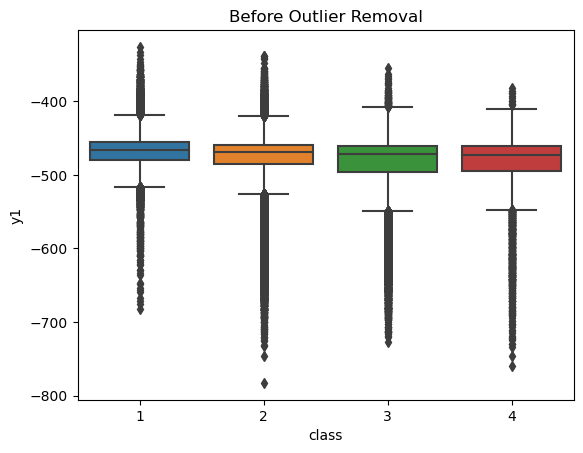

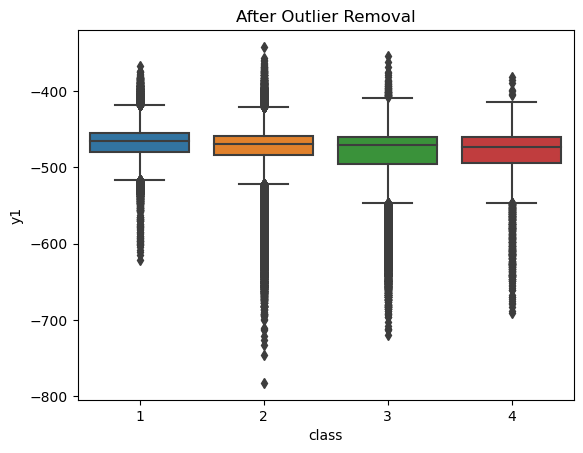

In [190]:
# 清理前的可视化
sns.boxplot(x='class', y='y1', data=data_with_class)
plt.title("Before Outlier Removal")
plt.show()

# 清理后的可视化
sns.boxplot(x='class', y='y1', data=denoised_data_with_class)
plt.title("After Outlier Removal")
plt.show()

DBSCAN AND IQR

In [22]:
# 使用 IQR 方法对每个类别的数据进行清理
def remove_outliers_iqr(df, multiplier=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    is_not_outlier = ~((df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))).any(axis=1)
    return df[is_not_outlier]

# 按类别进行清理
cleaned_data_list = []
for label in denoised_data_with_class['class'].unique():
    class_data = denoised_data_with_class[denoised_data_with_class['class'] == label]
    
    if label == 2:
        # 对类别 2 进行异常值清理
        class_features = class_data.drop(columns=['class'])
        cleaned_class_data = remove_outliers_iqr(class_features)
        # 将 'class' 列加回来
        cleaned_class_data['class'] = label
    else:
        # 其他类别保持不变
        cleaned_class_data = class_data
    
    cleaned_data_list.append(cleaned_class_data)

# 将清理后的数据合并成一个 DataFrame
cleaned_data_with_class = pd.concat(cleaned_data_list, ignore_index=True)

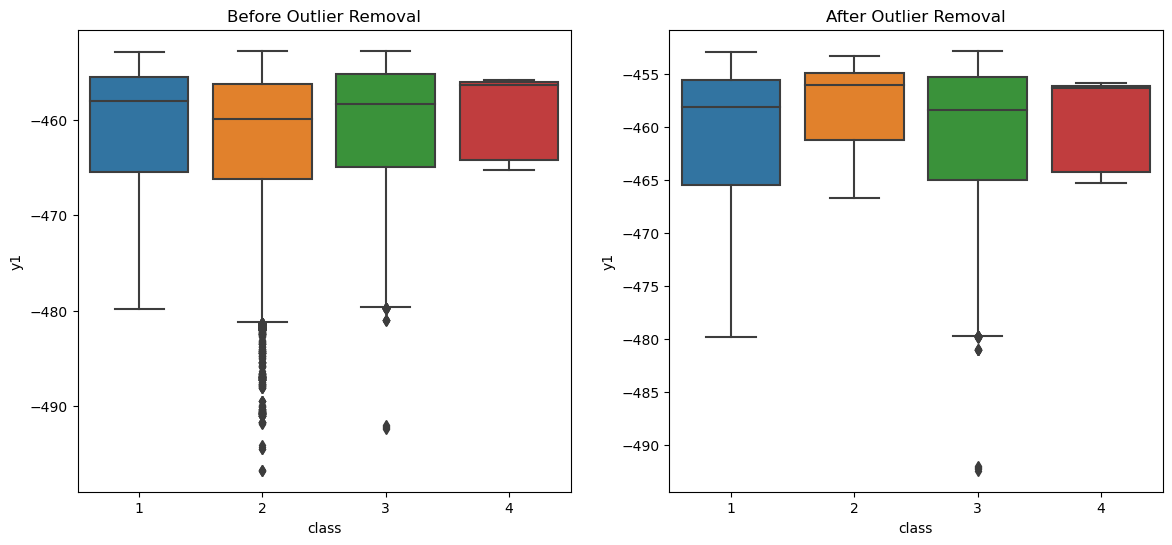

In [23]:
plt.figure(figsize=(14, 6))

# 第一个子图: y1 vs class
plt.subplot(1, 2, 1)
# 清理前的可视化
sns.boxplot(x='class', y='y1', data=denoised_data_with_class)
plt.title("Before Outlier Removal")
plt.subplot(1, 2, 2)
# 清理后的可视化
sns.boxplot(x='class', y='y1', data=cleaned_data_with_class)
plt.title("After Outlier Removal")
plt.show()

使用LOF方法

In [170]:
from sklearn.neighbors import LocalOutlierFactor

def remove_outliers_lof(df):
    # 创建LOF模型
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    
    # 预测异常值，返回-1的表示异常值
    y_pred = lof.fit_predict(df)
    
    # 保留正常的数据点
    df_cleaned = df[y_pred != -1]
    return df_cleaned

# 对每个类别的数据进行清理
cleaned_data_list = []
for label in data_with_class['class'].unique():
    class_data = data_with_class[data_with_class['class'] == label]
    class_features = class_data.drop(columns=['class'])
    
    # 清理每个类别中的异常值
    cleaned_class_data = remove_outliers_lof(class_features)
    
    # 将 'class' 列加回来
    cleaned_class_data['class'] = label
    
    cleaned_data_list.append(cleaned_class_data)

# 将清理后的数据合并成一个 DataFrame
cleaned_data_with_class = pd.concat(cleaned_data_list, ignore_index=True)

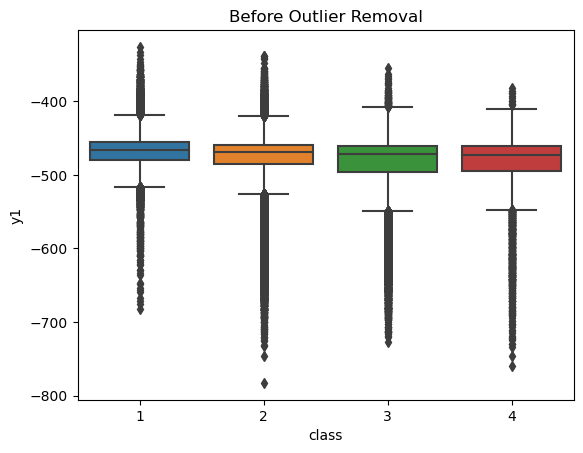

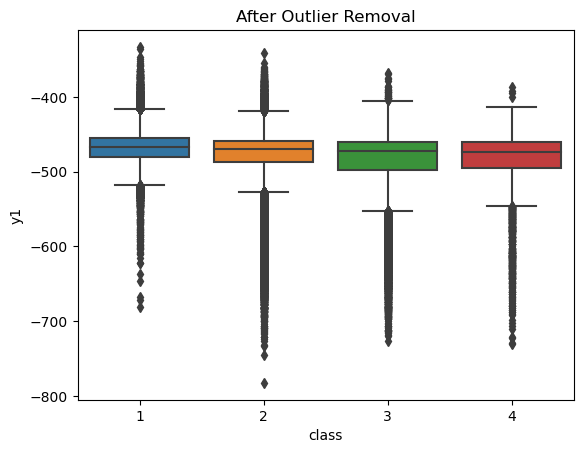

In [171]:
# 清理前的可视化
sns.boxplot(x='class', y='y1', data=data_with_class)
plt.title("Before Outlier Removal")
plt.show()

# 清理后的可视化
sns.boxplot(x='class', y='y1', data=cleaned_data_with_class)
plt.title("After Outlier Removal")
plt.show()

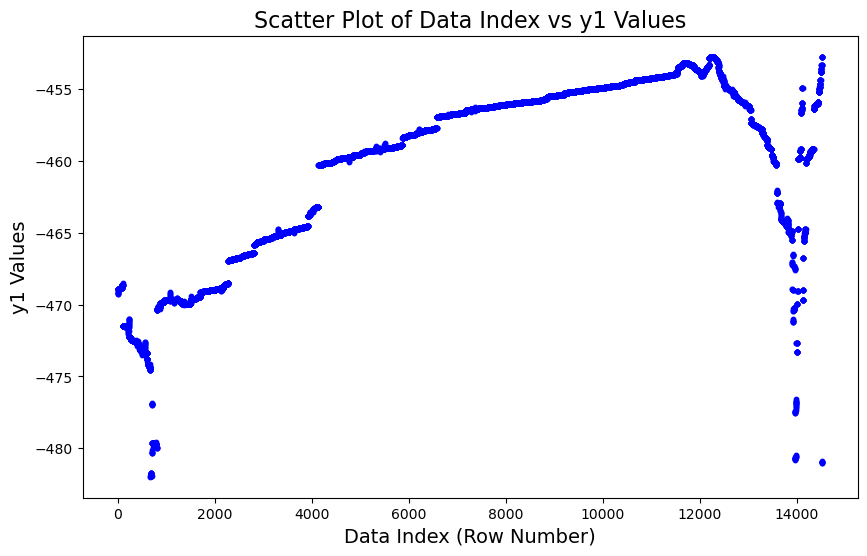

In [106]:
y1_values = denoised_data_with_class['x4'].values

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y1_values)), y1_values, color='blue', s=10)

# 添加标题和标签
plt.title('Scatter Plot of Data Index vs y1 Values', fontsize=16)
plt.xlabel('Data Index (Row Number)', fontsize=14)
plt.ylabel('y1 Values', fontsize=14)

# 显示图形
plt.show()

In [138]:
cleaned_data_with_class.to_excel('classes_DB_IQR.xlsx', index=False)

In [107]:
denoised_data_with_class.to_excel('classes_with_DBSCAN.xlsx',index=False)

In [108]:
data1 = pd.read_excel('classes_with_DBSCAN.xlsx')
data1.to_feather('classes_with_DBSCAN.feather')

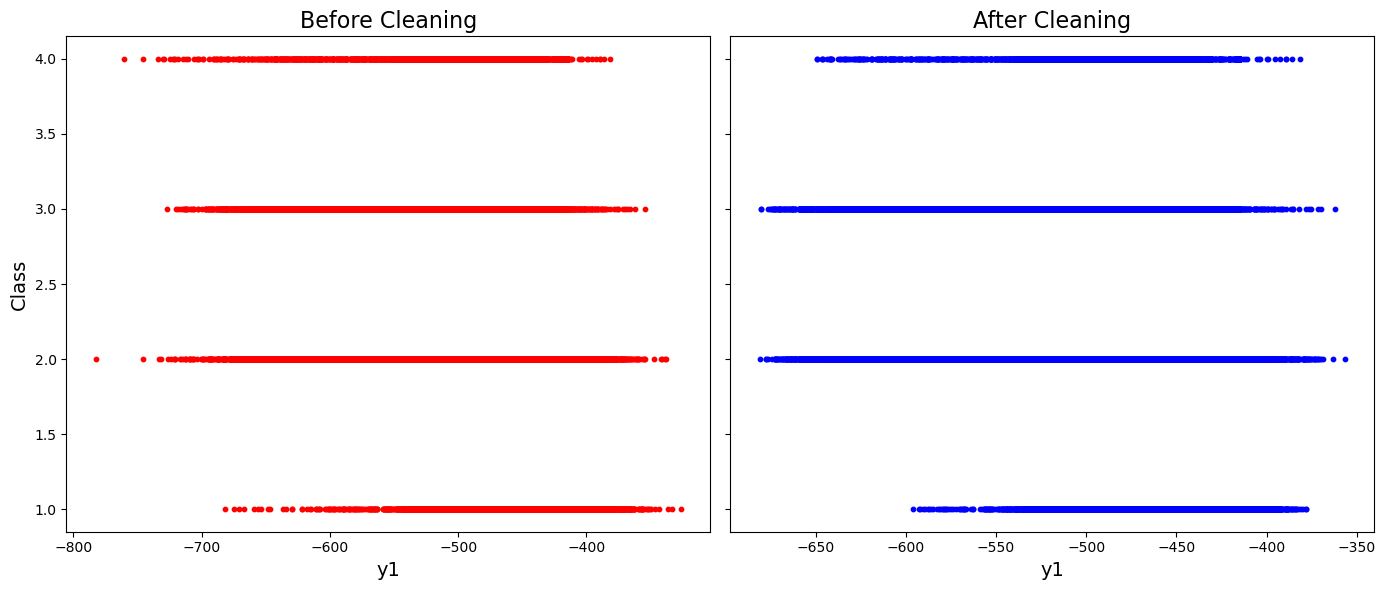

In [184]:
y1_values_before = data_with_class['y1']
class_values_before = data_with_class['class']

y1_values_after = denoised_data_with_class['y1']
class_values_after = denoised_data_with_class['class']

# 创建一行两列的子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 绘制处理前的数据散点图
axes[0].scatter(y1_values_before, class_values_before, color='red', s=10)
axes[0].set_title('Before Cleaning', fontsize=16)
axes[0].set_xlabel('y1', fontsize=14)
axes[0].set_ylabel('Class', fontsize=14)

# 绘制处理后的数据散点图
axes[1].scatter(y1_values_after, class_values_after, color='blue', s=10)
axes[1].set_title('After Cleaning', fontsize=16)
axes[1].set_xlabel('y1', fontsize=14)

# 显示图形
plt.tight_layout()
plt.show()

In [32]:
cleaned_data_with_class.to_feather('classes_DB_IQR.feather')
cleaned_data_with_class.to_excel('classes_DB_IQR.xlsx')

In [25]:
class_ = cleaned_data_with_class['class']
features = cleaned_data_with_class.drop(columns=['class'])

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(features)
y = pd.Series(class_)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  
from sklearn.feature_selection import RFE

rf = RandomForestClassifier()
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe = rfe.fit(x_train, y_train)
# 选择特征
x_train_rfe = rfe.transform(x_train)
x_test_rfe = rfe.transform(x_test)
# 在选择的特征上训练随机森林分类器
rf.fit(x_train_rfe, y_train)

# 计算训练和测试集的准确率
train_acc = metrics.accuracy_score(y_train, rf.predict(x_train_rfe))
test_acc = metrics.accuracy_score(y_test, rf.predict(x_test_rfe))

print(f'Train Accuracy: {train_acc}')
print(f'Test Accuracy: {test_acc}')

# 打印特征排名
print("Feature Ranking:", rfe.ranking_)

Train Accuracy: 0.9997841105354058
Test Accuracy: 0.8308157099697885
Feature Ranking: [71 46 60 78 25 34 92 89 63 13 42  1 51 67 21 10 39 48 40 52 70 29  1 85
 76 69  1 90 74 45 11 43  5  3  8 20  1 93 82  1 56 86  7  1 49 47 12 53
 24 22 37 38  6 57  9 50 77 91 81 84 33  1 35 26 54 18  1 66 14 65  1 94
 30  2  1 44 75 61 31 62 28  4 83 68 64 32 19 79 17 16 73 15 27 36 59 41
 80 87 23 72 55 88 58]


可视化特征排名

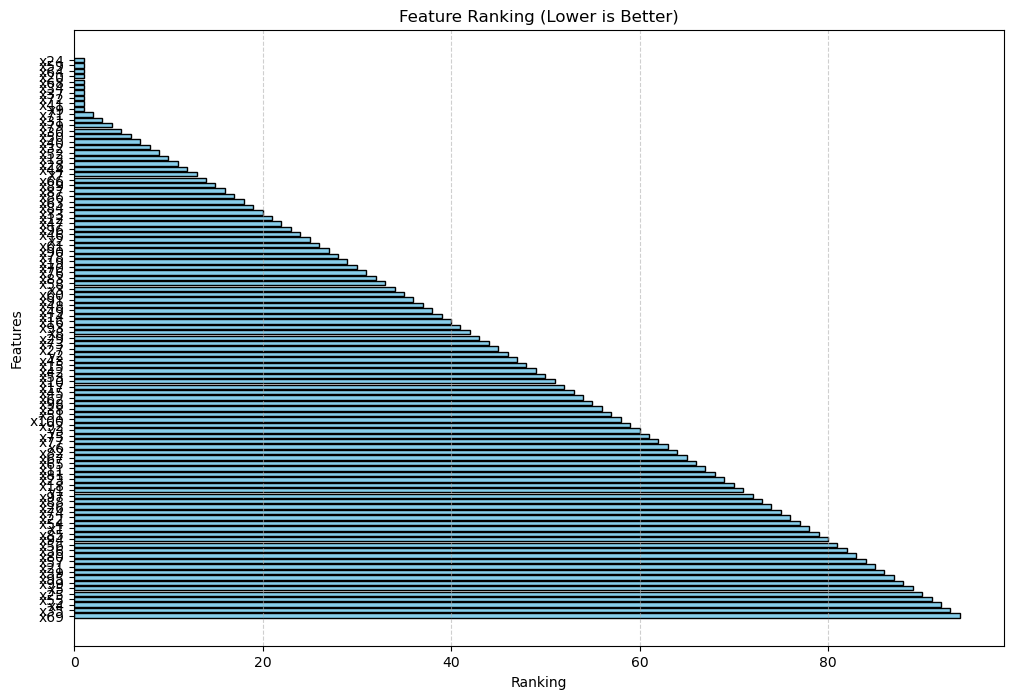

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 获取特征的重要性排名
feature_ranking = rfe.ranking_
feature_names = features.columns  # 替换为你实际的特征名称

# 将特征排名与特征名称结合为 DataFrame，并按照排名排序
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'Ranking': feature_ranking
})
ranking_df = ranking_df.sort_values('Ranking', ascending=True)

# 创建条形图
plt.figure(figsize=(12, 8))
plt.barh(ranking_df['Feature'], ranking_df['Ranking'], color='skyblue', edgecolor='black')
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking (Lower is Better)')
plt.gca().invert_yaxis()  # 排名越小的特征越靠上
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [35]:
# 输出前10个重要特征
top_10_features = ranking_df.head(10)
print("Top 10 Important Features:")
print(top_10_features)

Top 10 Important Features:
   Feature  Ranking
26     x24        1
61     x59        1
66     x64        1
22     x20        1
70     x68        1
36     x34        1
39     x37        1
74     x72        1
43     x41        1
11      x9        1


可视化混淆矩阵

<Figure size 800x800 with 0 Axes>

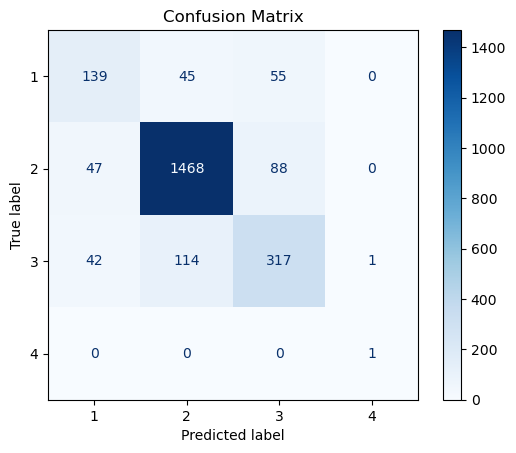

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 计算混淆矩阵
cm = confusion_matrix(y_test, rf.predict(x_test_rfe))
cmd = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)

# 绘制混淆矩阵
plt.figure(figsize=(8, 8))
cmd.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()